In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import xarray as xr
import sectionate
import xoverturning
import matplotlib.pyplot as plt

In [3]:
xr.set_options(display_style="text")

# Conservatively diagnosing model transports into an arbitrary closed region with `sectionate`

## Load example model grid and transport diagnosics

In [4]:
dir_pp = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_test_v6_proto2/gfdl.ncrc4-intel18-prod-openmp/pp/'

In [5]:
grid = xr.open_dataset(f"{dir_pp}/ocean_annual_rho2_d2/ocean_annual_rho2_d2.static.nc")
symmetric = grid['geolon_c'].shape!=grid['geolon'].shape
symmetric

True

In [6]:
grid

<xarray.Dataset>
Dimensions:       (yq: 1121, xq: 1441, yh: 1120, xh: 1440)
Coordinates:
  * xh            (xh) float64 -298.4 -298.2 -298.0 -297.7 ... 60.89 61.12 61.35
  * xq            (xq) float64 -298.5 -298.3 -298.1 -297.8 ... 61.0 61.23 61.35
  * yh            (yh) float64 -83.56 -83.48 -83.41 -83.33 ... 89.78 89.89 90.0
  * yq            (yq) float64 -83.6 -83.52 -83.45 -83.37 ... 89.84 89.95 90.0
Data variables: (12/27)
    Coriolis      (yq, xq) float32 ...
    areacello     (yh, xh) float32 ...
    areacello_bu  (yq, xq) float32 ...
    areacello_cu  (yh, xq) float32 ...
    areacello_cv  (yq, xh) float32 ...
    basin         (yh, xh) float64 ...
    ...            ...
    hfgeou        (yh, xh) float64 ...
    sftof         (yh, xh) float64 ...
    wet           (yh, xh) float64 ...
    wet_c         (yq, xq) float64 ...
    wet_u         (yh, xq) float64 ...
    wet_v         (yq, xh) float64 ...
Attributes:
    external_variables:  areacello areacello

In [7]:
ds = xr.open_mfdataset(f"{dir_pp}/ocean_annual_z_d2/av/annual_5yr/*.nc", decode_times=False)
ds = ds.assign_coords({
    'dxCv': xr.DataArray(grid['dxCv'].transpose('xh', 'yq').values, dims=('xh', 'yq',)),
    'dyCu': xr.DataArray(grid['dyCu'].transpose('xq', 'yh').values, dims=('xq', 'yh',))
})

In [8]:
ds

<xarray.Dataset>
Dimensions:                         (xh: 1440, yh: 1120, z_l: 35, z_i: 36,
                                     time: 3, nv: 2, xq: 1441, yq: 1121)
Coordinates:
  * xh                              (xh) float64 -298.6 -298.4 ... 60.93 61.16
  * yh                              (yh) float64 -83.62 -83.54 ... 89.81 89.92
  * z_l                             (z_l) float64 2.5 10.0 ... 6e+03 6.5e+03
  * z_i                             (z_i) float64 0.0 5.0 ... 6.25e+03 6.75e+03
  * time                            (time) float64 912.5 2.738e+03 4.562e+03
  * nv                              (nv) float64 1.0 2.0
  * xq                              (xq) float64 -298.6 -298.4 ... 61.12 61.35
  * yq                              (yq) float64 -83.64 -83.56 ... 89.89 90.0
    dxCv                            (xh, yq) float32 3.422e+03 ... 1.215e+04
    dyCu                            (xq, yh) float32 7.684e+03 ... 0.04939
Data variables: (12/43)
    volcello                        (time, z_l, yh, xh) float32 dask.array<chunksize=(1, 35, 1120, 1440), meta=np.ndarray>
    thetao                          (time, z_l, yh, xh) float32 dask.array<chunksize=(1, 35, 1120, 1440), meta=np.ndarray>
    so                              (time, z_l, yh, xh) float32 dask.array<chunksize=(1, 35, 1120, 1440), meta=np.ndarray>
    obvfsq                          (time, z_i, yh, xh) float32 dask.array<chunksize=(1, 36, 1120, 1440), meta=np.ndarray>
    agessc                          (time, z_l, yh, xh) float32 dask.array<chunksize=(1, 35, 1120, 1440), meta=np.ndarray>
    uo                              (time, z_l, yh, xq) float32 dask.array<chunksize=(1, 35, 1120, 1441), meta=np.ndarray>
    ...                              ...
    Kd_BBL                          (time, z_i, yh, xh) float32 dask.array<chunksize=(1, 36, 1120, 1440), meta=np.ndarray>
    Kd_ePBL                         (time, z_i, yh, xh) float32 dask.array<chunksize=(1, 36, 1120, 1440), meta=np.ndarray>
    time_bnds                       (time, nv) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    average_T1                      (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2                      (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    average_DT                      (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    title:             CM4_piControl_c192_OM4p125_test_v6_proto2
    grid_type:         regular
    grid_tile:         N/A
    associated_files:  areacello: ocean_static_d2.nc
    history:           Tue Jul  6 20:17:04 2021: ncatted -O -a associated_fil...
    NCO:               netCDF Operators version 4.7.9 (Homepage = http://nco....
    comment:           FMS time averaging, version 3.0, precision=double
    filename:          ocean_annual_z_d2.0001-0005.ann.nc

## Define the two OSNAP sections:

In [9]:
Labrador_section_lons=[-56.8775, -52.0956, -49.8604, -47.6107, -44.8000, -50, -65, -65]
Labrador_section_lats=[52.0166, 52.6648, 53.5577, 58.8944, 60.4000, 71, 63.5, 57.5]
Labrador_section_lons = np.append(Labrador_section_lons, Labrador_section_lons[0])
Labrador_section_lats = np.append(Labrador_section_lats, Labrador_section_lats[0])

## Closed section surrounding Labrador Sea

Specifying `closed=True` ensures that the end-point is not double-counted

In [10]:
i, j, x, y = sectionate.create_section_composite(
    grid['geolon_c'],
    grid['geolat_c'],
    Labrador_section_lons,
    Labrador_section_lats,
    symmetric,
    closed=True
)

In [11]:
grid

<xarray.Dataset>
Dimensions:       (yq: 1121, xq: 1441, yh: 1120, xh: 1440)
Coordinates:
  * xh            (xh) float64 -298.4 -298.2 -298.0 -297.7 ... 60.89 61.12 61.35
  * xq            (xq) float64 -298.5 -298.3 -298.1 -297.8 ... 61.0 61.23 61.35
  * yh            (yh) float64 -83.56 -83.48 -83.41 -83.33 ... 89.78 89.89 90.0
  * yq            (yq) float64 -83.6 -83.52 -83.45 -83.37 ... 89.84 89.95 90.0
Data variables: (12/27)
    Coriolis      (yq, xq) float32 ...
    areacello     (yh, xh) float32 ...
    areacello_bu  (yq, xq) float32 ...
    areacello_cu  (yh, xq) float32 ...
    areacello_cv  (yq, xh) float32 ...
    basin         (yh, xh) float64 ...
    ...            ...
    hfgeou        (yh, xh) float64 ...
    sftof         (yh, xh) float64 ...
    wet           (yh, xh) float64 ...
    wet_c         (yq, xq) float64 ...
    wet_u         (yh, xq) float64 ...
    wet_v         (yq, xh) float64 ...
Attributes:
    external_variables:  areacello areacello

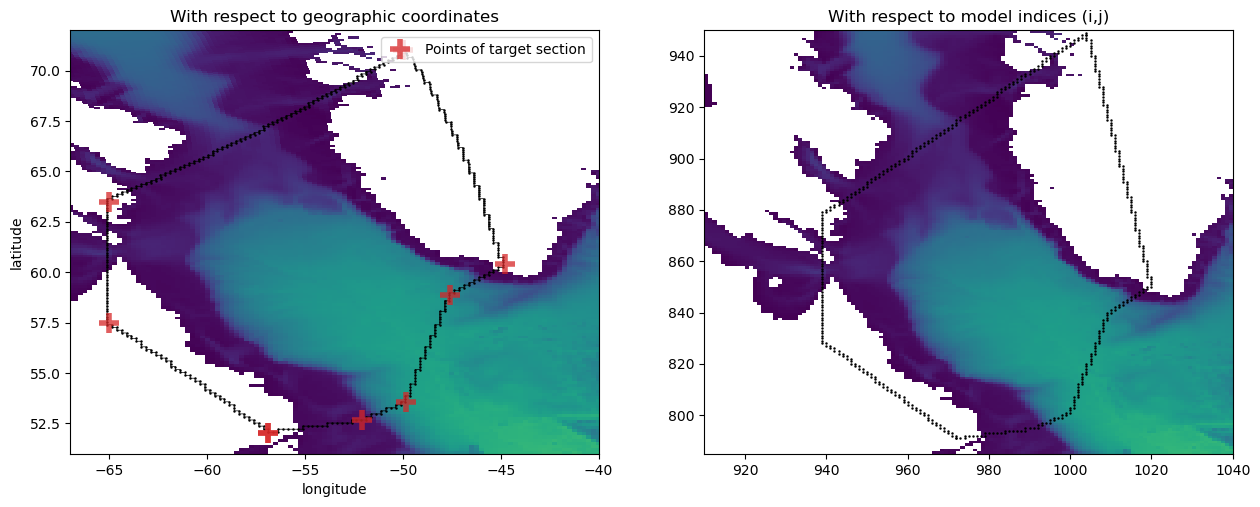

In [12]:
depth_masked = grid['deptho'].where(grid['deptho'] != 0)

plt.figure(figsize=[15,5.5])
plt.subplot(1,2,1)
plt.pcolormesh(grid['geolon_c'], grid['geolat_c'], depth_masked)
plt.plot(x, y, 'k.-', markersize=1.5, lw=0.5)
plt.plot(Labrador_section_lons, Labrador_section_lats, "C3+", markersize=15., mew=4., alpha=0.75, label="Points of target section")
plt.axis([-67,-40, 51, 72])
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("With respect to geographic coordinates")
plt.legend(loc="upper right")

plt.subplot(1,2,2)
plt.pcolormesh(depth_masked)
plt.plot(i, j, 'k.', markersize=1.5, lw=0.5)
plt.axis([910, 1040, 785, 950])
plt.title("With respect to model indices (i,j)")
plt.show()

### Plot the hydrography and cell-integrated mass transport across the section

In [13]:
T = sectionate.extract_tracer(ds['thetao'], i, j, symmetric)

In [14]:
Trp = sectionate.convergent_transport(ds, i, j, symmetric, counterclockwise=True)

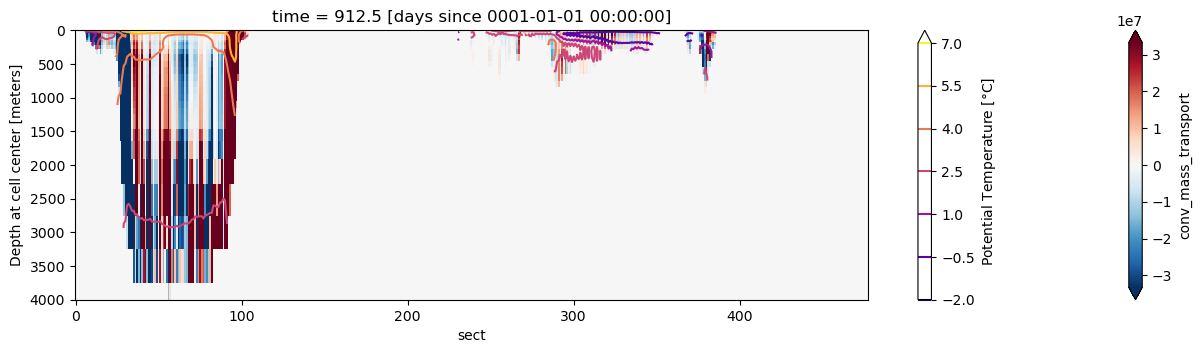

In [15]:
plt.figure(figsize=(16, 3.5))
Trp.isel(time=0)['conv_mass_transport'].plot(cmap='RdBu_r', yincrease=False, ylim=[4000,0], robust=True)
cs = T.isel(time=0).plot.contour(vmin=-2, vmax=7, cmap='plasma', yincrease=False, ylim=[4000,0])
plt.colorbar(cs, label=r"Potential Temperature [$\degree$C]")

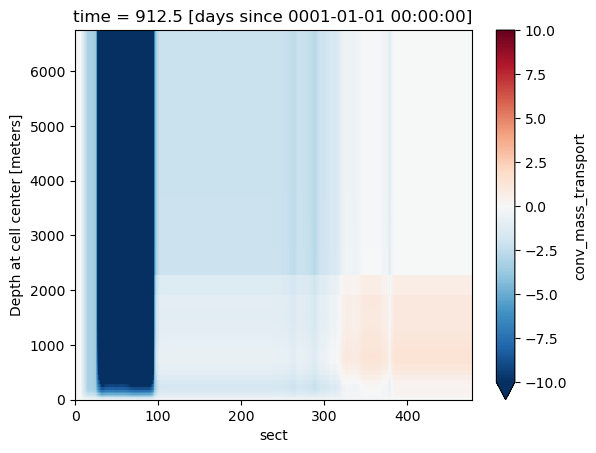

In [16]:
rho0 = 1035.
(Trp['conv_mass_transport'].isel(time=0).cumsum("sect").cumsum("z_l") / rho0*1e-6).plot(cmap="RdBu_r", vmin=-10, vmax=10)

## Diagnosing overturning streamfunctions in depth and density space

In [17]:
names_z = {'x_center': 'sect',
         'layer': 'z_l',
         'interface': 'z_i'}

names_rho2 = {'x_center': 'sect',
              'layer': 'rho2_l',
              'interface': 'rho2_i'}

In [18]:
ovt = xoverturning.compfunc.compute_streamfunction(Trp, names_z, transport='conv_mass_transport', fromtop=True)

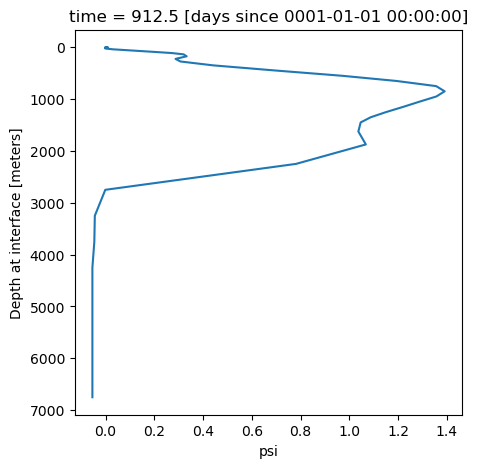

In [19]:
ovt.isel(time=0).plot(y='z_i', yincrease=False, figsize=[5,5])

In [20]:
ds_rho2 = xr.open_mfdataset(f"{dir_pp}/ocean_annual_rho2_d2/av/annual_5yr/*.nc", decode_times=False)

In [21]:
ds_rho2

<xarray.Dataset>
Dimensions:     (xh: 1440, yh: 1120, rho2_l: 35, rho2_i: 36, time: 1, nv: 2,
                 xq: 1441, yq: 1121)
Coordinates:
  * xh          (xh) float64 -298.6 -298.4 -298.1 -297.9 ... 60.7 60.93 61.16
  * yh          (yh) float64 -83.62 -83.54 -83.46 -83.39 ... 89.7 89.81 89.92
  * rho2_l      (rho2_l) float64 1.014e+03 1.028e+03 ... 1.037e+03 1.038e+03
  * rho2_i      (rho2_i) float64 999.5 1.028e+03 ... 1.037e+03 1.038e+03
  * time        (time) float64 912.5
  * nv          (nv) float64 1.0 2.0
  * xq          (xq) float64 -298.6 -298.4 -298.2 -298.0 ... 60.89 61.12 61.35
  * yq          (yq) float64 -83.64 -83.56 -83.48 -83.41 ... 89.78 89.89 90.0
Data variables:
    volcello    (time, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 35, 1120, 1440), meta=np.ndarray>
    thkcello    (time, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 35, 1120, 1440), meta=np.ndarray>
    umo         (time, rho2_l, yh, xq) float32 dask.array<chunksize=(1, 35, 1120, 1441), meta=np.ndarray>
    uhml        (time, rho2_l, yh, xq) float32 dask.array<chunksize=(1, 35, 1120, 1441), meta=np.ndarray>
    vmo         (time, rho2_l, yq, xh) float32 dask.array<chunksize=(1, 35, 1121, 1440), meta=np.ndarray>
    vhml        (time, rho2_l, yq, xh) float32 dask.array<chunksize=(1, 35, 1121, 1440), meta=np.ndarray>
    time_bnds   (time, nv) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    average_T1  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    average_DT  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    title:             CM4_piControl_c192_OM4p125_test_v6_proto2
    grid_type:         regular
    grid_tile:         N/A
    associated_files:  areacello: ocean_static_d2.nc
    history:           Tue Jul  6 20:17:04 2021: ncatted -O -a associated_fil...
    NCO:               netCDF Operators version 4.7.9 (Homepage = http://nco....
    comment:           FMS time averaging, version 3.0, precision=double
    filename:          ocean_annual_rho2_d2.0001-0005.ann.nc

In [22]:
Trp_rho2 = sectionate.convergent_transport(ds_rho2, i, j, symmetric, layer='rho2_l', interface='rho2_i', counterclockwise=True)

(1035.0, 1038.0)

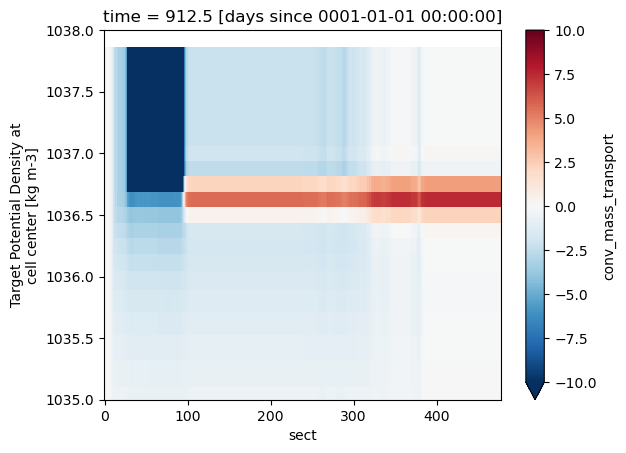

In [23]:
(Trp_rho2['conv_mass_transport'].isel(time=0).cumsum("sect").cumsum("rho2_l") / rho0*1e-6).plot(cmap="RdBu_r", vmin=-10, vmax=10)
plt.ylim(1035, 1038)

In [24]:
ovt_rho2 = xoverturning.compfunc.compute_streamfunction(Trp_rho2, names_rho2, transport='conv_mass_transport', fromtop=True)

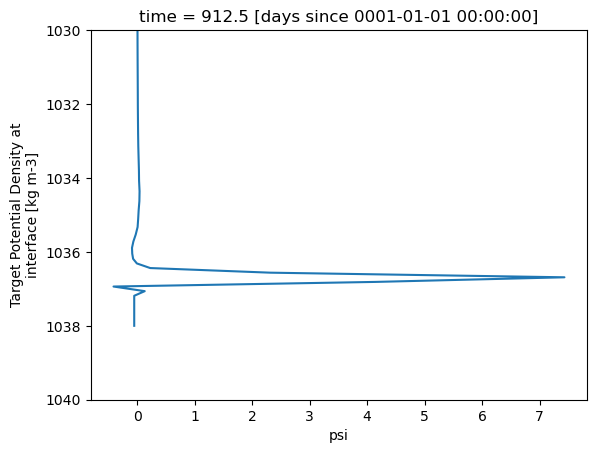

In [25]:
ovt_rho2.isel(time=0).plot(y='rho2_i', yincrease=False, ylim=[1040,1030])

In [26]:
Trp_rho2 = sectionate.convergent_transport(ds_rho2, i, j, symmetric, layer='rho2_l', interface='rho2_i', counterclockwise=True)

In [27]:
ovt_rho2 = xoverturning.compfunc.compute_streamfunction(Trp_rho2, names_rho2, transport='conv_mass_transport', fromtop=True)

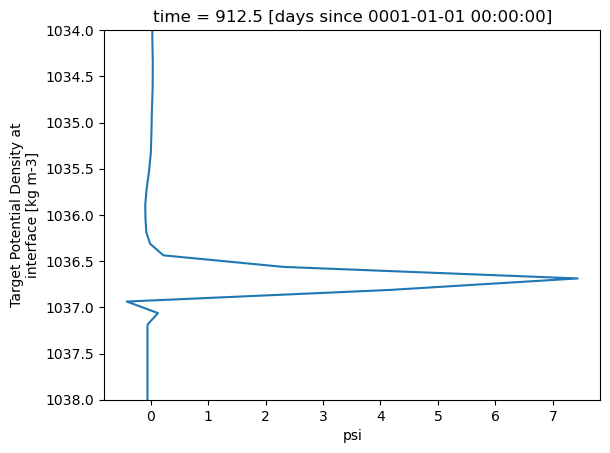

In [28]:
ovt_rho2.isel(time=0).plot(y='rho2_i', yincrease=False, ylim=[1038,1034])

In [29]:
np.isclose(ovt.isel(time=0).isel(z_i=-1).compute(), ovt_rho2.isel(time=0).isel(rho2_i=-1).compute(), rtol=1.e-4)

True